In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import lbg_forecast.sfh as sfh
import matplotlib.pyplot as plt
import joblib

#run = 'hpc120'
nsamples = 10000000
#spsp = np.load("sps_parameter_samples/sps_"+run+".npy")
#training_data = np.vstack(spsp)[:nsamples, :]

#input
train_redshift = np.random.uniform(0, 7, (nsamples, 1))#np.reshape(training_data[:, 0], (nsamples, 1))
train_mass = np.random.uniform(7, 13, (nsamples, 1))#np.log10(np.reshape(training_data[:, -1], (nsamples, 1)))
train_logsfrratios = np.random.uniform(-5, 5, (nsamples, 6))

x = np.hstack((train_redshift, train_logsfrratios ,train_mass))
print(x.shape)

#output
y = np.log10(sfh.calculate_recent_sfr(np.squeeze(train_redshift), np.squeeze(10**train_mass), train_logsfrratios))
#plt.scatter(train_recent_sfrs, training_data[:, 3])

np.save("sfr_emulator/train_x.npy", x)
np.save("sfr_emulator/train_y.npy", y)

In [11]:
x = np.load("sfr_emulator/train_x.npy")
y = np.load("sfr_emulator/train_y.npy")
regressor = RandomForestRegressor(n_estimators=20, max_depth=10)

In [12]:
for iter in range(1):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Iteration: ", iter, "MSE: ", mse)

Iteration:  0 MSE:  1.8213847768068552


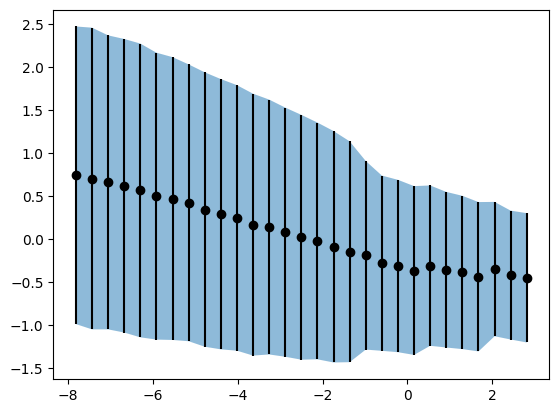

In [15]:
import scipy as sc
def process_samples(x, y, xl, xh, ngrid=15):

    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, y, 'mean', np.linspace(xl, xh, ngrid))
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, y, 'std', np.linspace(xl, xh, ngrid))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    return bin_centers, bin_means, bin_std

percentage_error = (y_pred-y_test)#)/y_test)*100
#plt.scatter(x_test[:, 0], percentage_error)

bin_centers, bin_means, bin_std = process_samples(y_test, percentage_error, -8, 3, 30)
plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko')
plt.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.5)

In [14]:
joblib.dump(regressor, 'sfr_emulator/sfr_emulator.pkl')

['sfr_emulator/sfr_emulator.pkl']

In [5]:
#run = 'hpc120'
#nsamples = 10000000
#spsp = np.load("sps_parameter_samples/sps_"+run+".npy")
#training_data = np.vstack(spsp)[:nsamples, :]

In [6]:
#n=1000
#plt.scatter(y[-n:], training_data[-n:, 3], alpha=0.5)
#plt.scatter(regressor.predict(x[-n:]), training_data[-n:, 3], alpha=0.5)